#NLP Project

Create an NLP model to classify abstract sentences into their part (e.g. objective, methods, results, etc) 

Dataset in from : ***Pubmed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*** ('https://arxiv.org/abs/1710.06071')

Model i'm going to rebuild exciting model from : ***Neural Networks for Joint Sentence Classification in Medical Paper Abstracts*** ('https://arxiv.org/pdf/1612.05251.pdf)




In [1]:
!nvidia-smi

Sat Jan 21 08:51:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

tf.__version__

'2.9.2'

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess and explore dataset

In [7]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] 

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [14]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

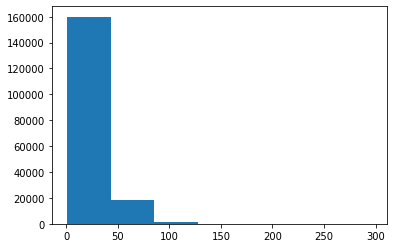

In [17]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [18]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [19]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
train_df['line_number']. value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

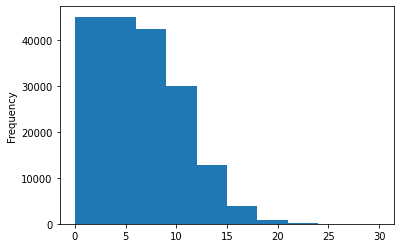

In [21]:
train_df.line_number.plot.hist();

In [22]:
np.percentile(train_df.total_lines, 98)

20.0

In [23]:
#Use Tensorflow
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [24]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [25]:
train_df['total_lines']. value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

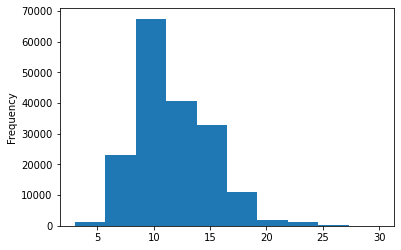

In [26]:
train_df.total_lines.plot.hist();

In [27]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [28]:
train_total_line_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_line_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth =20)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [29]:
train_total_line_one_hot.shape, train_total_line_one_hot[:20]

(TensorShape([180040, 20]), <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#Feature Extraction token embedding

In [30]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [31]:
import random
random_training_sentence = random.choice(train_sentences)
print(f'Random training sentence : \n {random_training_sentence}\n')

use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f'Sentence after embedding :\n {use_embedded_sentence[0][:25]} (etc)....')
print(f'Length of sentence embedding : \n {len(use_embedded_sentence[0])}')

Random training sentence : 
 the present study aimed to investigate this possibility .

Sentence after embedding :
 [ 0.09406623  0.06751827 -0.00659879 -0.06551    -0.03622358 -0.00153017
 -0.03580404 -0.02478939  0.07861175 -0.00565074 -0.0238171  -0.00263205
  0.09097928 -0.01989255 -0.03442699 -0.0688824   0.01985713  0.0031995
  0.08131157 -0.07894144 -0.06371669 -0.02426042 -0.04856876 -0.06330707
 -0.01344557] (etc)....
Length of sentence embedding : 
 512


# Characterize tokenizer

In [32]:
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character
split_chars(random_training_sentence)

't h e   p r e s e n t   s t u d y   a i m e d   t o   i n v e s t i g a t e   t h i s   p o s s i b i l i t y   .'

In [33]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [34]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len
     

149.3662574983337

In [35]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [36]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
max_tokens = 68000

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences
     

In [38]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [39]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of character: {len(char_vocab)}"), 
print(f"Most common words charecter: {char_vocab[:5]}")
print(f"Least common words character: {char_vocab[-5:]}")

Number of character: 28
Most common words charecter: ['', '[UNK]', 'e', 't', 'i']
Least common words character: ['k', 'x', 'z', 'q', 'j']


In [40]:
random_train_chars = random.choice(train_chars)
print(f"original text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

original text:
m i n i m i s i n g   t i m e   s p e n t   i n   h o s p i t a l   i s   o f   h i g h   p r i o r i t y   t o   p a t i e n t s   a n d   t h e i r   f a m i l i e s   .

Length of chars: 72

Vectorized chars:
[[15  4  6  4 15  4  9  4  6 18  3  4 15  2  9 14  2  6  3  4  6 13  7  9
  14  4  3  5 12  4  9  7 17 13  4 18 13 14  8  4  7  8  4  3 19  3  7 14
   5  3  4  2  6  3  9  5  6 10  3 13  2  4  8 17  5 15  4 12  4  2  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  

In [41]:
char_embedding = tf.keras.layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                                           output_dim = 25,
                                           mask_zero=False,
                                           name='char_embed')

#Test
print(f'before vertorization adn embedding : \n {random_train_chars} \n')
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f'After vectorization aand embedding :\n {char_embed_example} \n')

before vertorization adn embedding : 
 m i n i m i s i n g   t i m e   s p e n t   i n   h o s p i t a l   i s   o f   h i g h   p r i o r i t y   t o   p a t i e n t s   a n d   t h e i r   f a m i l i e s   . 

After vectorization aand embedding :
 [[[-0.02134602 -0.03979165 -0.02634786 ... -0.03875283 -0.01338052
   -0.00541642]
  [-0.01873736  0.00181342 -0.02346684 ...  0.04384771  0.01798156
   -0.01094916]
  [-0.03544991 -0.00521786 -0.02914927 ... -0.02195724 -0.03132942
    0.02652167]
  ...
  [ 0.04907748  0.01969654 -0.04038687 ... -0.01495837  0.01914999
   -0.02640503]
  [ 0.04907748  0.01969654 -0.04038687 ... -0.01495837  0.01914999
   -0.02640503]
  [ 0.04907748  0.01969654 -0.04038687 ... -0.01495837  0.01914999
   -0.02640503]]] 



#Combine all dataset

In [44]:
#Training data
train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                 train_total_line_one_hot,
                                                 train_sentences,
                                                 train_chars))
train_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_dataset = tf.data.Dataset.zip((train_data, train_labels)) #combine tain data and train labels

#Validation_data
val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                              val_total_line_one_hot,
                                              val_sentences,
                                              val_chars))
val_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_dataset = tf.data.Dataset.zip((val_data, val_labels))



In [45]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Build a Model

In [46]:
from tensorflow.keras import layers, Model

#Token Input
token_input = layers.Input(shape=[], dtype='string', name= 'toke_input')
token_embd = tf_hub_embedding_layer(token_input)
token_out = layers.Dense(128, activation='relu')(token_embd)
token_model = Model(inputs=token_input,
                    outputs=token_out)

# Char Input
char_input = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vector = char_vectorizer(char_input)
char_embd = char_embedding(char_vector)
char_bi_ltsm =layers.Bidirectional(layers.LSTM(32))(char_embd)
char_model = Model(inputs = char_input,
                   outputs = char_bi_ltsm)

#Line Number Inputs
line_number_input = layers.Input(shape=(15,), dtype=tf.int32, name='line_numer_input')
line_number_out = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = Model(inputs = line_number_input,
                          outputs = line_number_out)

#Total line input
total_line_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_line_input')
total_line_out = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = Model(inputs= total_line_inputs,
                         outputs = total_line_out)

#Combine token and char embedding
combine = layers.Concatenate(name='combine_toke_char')([token_model.output,
                                                       char_model.output])
x = layers.Dense(256, activation='relu')(combine)
x = layers.Dropout(0.5)(x)

#Combine Line and total line model with Token & Char embedding
x = layers.Concatenate(name='all_combined')([line_number_model.output,
                                             total_line_model.output,
                                             x])
#Output layer
output_layer = layers.Dense(5,activation='softmax', name='output_layer')(x)

#Create model
model = Model(inputs=[line_number_model.input,
                      total_line_model.input,
                      token_model.input,
                      char_model.input],
              outputs = output_layer)

In [47]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 toke_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['toke_input[0][0]']       

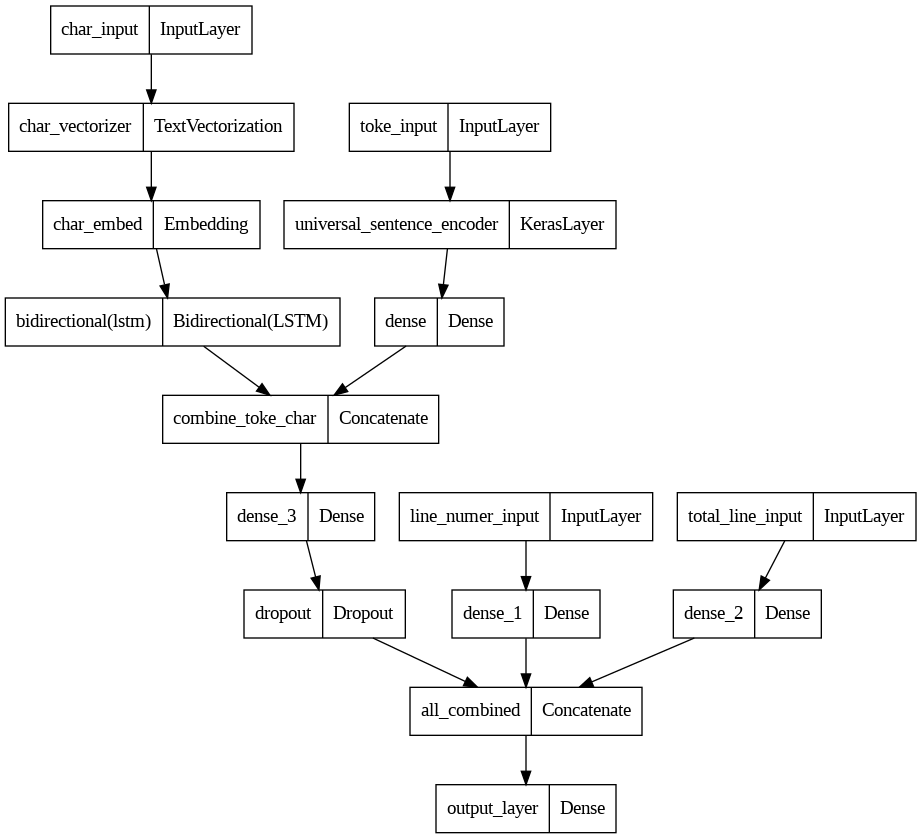

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [50]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset
                              )

Epoch 1/5
5627/5627 [==============================] - 206s 36ms/step - loss: 0.4082 - accuracy: 0.8457 - val_loss: 0.3709 - val_accuracy: 0.8563
Epoch 2/5
5627/5627 [==============================] - 231s 41ms/step - loss: 0.3601 - accuracy: 0.8649 - val_loss: 0.3558 - val_accuracy: 0.8633
Epoch 3/5
5627/5627 [==============================] - 244s 43ms/step - loss: 0.3357 - accuracy: 0.8741 - val_loss: 0.3493 - val_accuracy: 0.8663
Epoch 4/5
5627/5627 [==============================] - 205s 36ms/step - loss: 0.3202 - accuracy: 0.8800 - val_loss: 0.3466 - val_accuracy: 0.8695
Epoch 5/5
5627/5627 [==============================] - 204s 36ms/step - loss: 0.3063 - accuracy: 0.8854 - val_loss: 0.3483 - val_accuracy: 0.8693


#Evaluate Model

In [56]:
test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                test_total_line_one_hot,
                                                test_sentences,
                                                test_chars))

test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [57]:
test_pred_probs = model.predict(test_dataset,
                                verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 21s 21ms/step


In [61]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [64]:
from sklearn.metrics import classification_report

model_results = classification_report(y_true=test_labels_encoded,
                                              y_pred=test_preds)
print(model_results)

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      3621
           1       0.91      0.90      0.90      4571
           2       0.90      0.90      0.90      9897
           3       0.78      0.53      0.63      2333
           4       0.88      0.91      0.89      9713

    accuracy                           0.86     30135
   macro avg       0.84      0.81      0.82     30135
weighted avg       0.86      0.86      0.86     30135



In [70]:
# Find Most Wrong
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

In [66]:
test_df["prediction"] = test_pred_classes # column prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # column prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] #Binari column right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,BACKGROUND,0.516470,True
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.942054,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.986265,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.851590,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.995521,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.999590,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.918012,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.992990,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.949847,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.784671,True


In [67]:
top_50_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:50]
top_50_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.999992,False
24667,OBJECTIVE,we assessed mucosal cooling in two groups of p...,2,10,METHODS,0.999937,False
25664,CONCLUSIONS,rifampicin significantly increased the mean ar...,6,11,RESULTS,0.999910,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.999898,False
23202,RESULTS,the prebious trial has the potential to demons...,6,6,CONCLUSIONS,0.999885,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.999867,False
12158,METHODS,"in the saffron group , there was no decline in...",9,12,RESULTS,0.999817,False
23656,CONCLUSIONS,"time until stable health status , length of ca...",9,14,RESULTS,0.999758,False
14003,METHODS,while they had difference through anti-dizzy t...,7,8,RESULTS,0.999679,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.999667,False


In [68]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
#save_dir = "/content/drive/MyDrive/Dataset Noor Muhamad Rizki/ NLP Project PUBMED"
#os.makedirs(save_dir) # Make directory 

# # Save model
#model.save(save_dir)